In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import ndimage
import scipy
import glob
import os
import random

In [17]:
def read_and_grayscale_images(folderName, imgFolders, imgNames):
    image_dict={}
    color_img_dict={}

    for folder in imgFolders:
        image_list=[]
        color_list=[]
        for file in imgNames[folder]:
            path = folderName + folder +'/' + file   
            image = cv2.imread(path)
            image = cv2.resize(image,None,fx=scale[folder][0], fy=scale[folder][1], interpolation=cv2.INTER_CUBIC )
            imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
            color_list.append(image)
            image_list.append(gray)   
            
        image_dict[folder]= image_list
        color_img_dict[folder]=color_list
        
    return image_dict,color_img_dict

In [38]:
folderName = './images/'
imgFolders = ['Scene1'
              ,'Scene2'
              ,'Scene3','Scene4','Scene5'
             ]
imgNames ={'Scene1':[ 'reference.png','source.png']
           , 'Scene2':[ 'reference.png','source.png']
           , 'Scene3':[ 'reference.jpg','source.jpg']
           , 'Scene4':[ 'reference.jpg','source.jpg']
           , 'Scene5':[ 'reference.png','source.png']
          }
scale = {'Scene1':(1,1),'Scene2':(0.2,0.2),'Scene3':(0.2,0.2),
         'Scene4':(0.2,0.2),'Scene5':(0.2,0.2)
        }

In [5]:
def feature_detection(image):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    return kp, des

In [6]:
def feature_matching(img1, img2, num_iter=100,tolerance=2,threshold=0.8):
    
#     img1 --> reference image
#     img2 --> source image
    
    kp1, des1 = feature_detection(img1)
    kp2, des2 = feature_detection(img2)
    
    dist = scipy.spatial.distance.cdist(des1,des2,'euclidean')    
    matches={}
    for i, des in enumerate(dist):
        val = np.argpartition(des, 2)[:2]
        matches[i,val[0],val[1]] = [des[val[0]],des[val[1]]]
    
    factor=0.5
    good_matches=[]
    for key in matches:
        if matches[key][0] < factor*matches[key][1]:
            good_matches.append((key[0],key[1]))

    if len(good_matches) > 12:
        point_pairs=[]
        for index_pair in good_matches:
            kp_img1 = kp1[index_pair[0]].pt
            kp_img2 = kp2[index_pair[1]].pt
            point_pairs.append((kp_img1,kp_img2))
                        
        F,s = run_RANSAC(point_pairs,num_iter,tolerance,threshold)
        
    else:
        print("Not enough keypoints present")
        return 0
    
    return F, s

In [7]:
def findFundamentalMatrix(point_correspondances):
    n = len(point_correspondances)
    A = np.zeros((2*n,9))
    
    for i in range(n):
        x,y = point_correspondances[i][0]
        x_,y_ = point_correspondances[i][1]
        
        A[i: ]=[x*x_, x*y_, x, y*x_, y*y_, y , x_, y_, 1]

    U,D,V = np.linalg.svd(A, full_matrices= True)
    F = V[-1].reshape(3,3)
    
    if F[2,2]!=0:
        F /= F[2,2]
    
    return F

In [8]:
def findInliers(F, point_pairs, tolerance=1):
    inliers=[]
    for pt in point_pairs:
        x, y = pt[0]
        x_ , y_ = pt[1]
        
        norm_src_pt = np.matrix([x, y, 1]).T
        norm_des_pt = np.matrix([x_, y_, 1]) 
                
        epipolar_constraint = norm_des_pt*F*norm_src_pt
    
        if abs(epipolar_constraint)<tolerance:
            inliers.append(pt)
        
    return inliers    

In [9]:
def run_RANSAC(point_pairs, num_iter=100, tolerance=2, threshold=0.8):

    inliers_lst = []
    inliers_count =[]

    for i in range(num_iter):
        point_correspondances = random.choices(point_pairs, k=8)
        F = findFundamentalMatrix(point_correspondances)
        s = findInliers(F,point_pairs,tolerance)
        inliers_lst.append(s)
        inliers_count.append(len(s))
        
        if len(s) >= int(threshold*len(point_pairs)):
            F_final = findFundamentalMatrix(s)
            return (F_final,s)
        
    inliers_max = inliers_count.index(max(inliers_count))
        
    s = inliers_lst[inliers_max]
    F_final = findFundamentalMatrix(s)
    
    return (F_final,s)

In [10]:
def findEpipolarLines(points,F):
    lines = []
    for pt in points:
        x, y = pt
        pt_norm = np.array([x,y,1]).T
        line = np.matmul(F,pt_norm)
#         line = line.reshape(-1,3)
#         print(line)
        a,b,c=line
        k=1/((a**2+b**2)**(1/2))
        line = k*line
#         print(line)
        lines.append(line)
    return lines

In [11]:
def in_built_function_implementation(img1, img2):
    kp1, des1 = feature_detection(img1)
    kp2, des2 = feature_detection(img2)

    bf = cv2.BFMatcher(normType = cv2.NORM_L2)
    matches = bf.knnMatch(des1,des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5*n.distance:
            good_matches.append(m)           
    good_matches = np.asarray(good_matches)
    
    if len(good_matches) > 12:
        src = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
        dst = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
        F, s = cv2.findFundamentalMat(src,dst)
    
    return F,s

In [12]:
def all_points(image):
    
    points = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            points.append(np.array((i,j)))
    points = np.array(points)
    
    return points

In [13]:
def findCorrespondingPoints(line,image):
    a,b,c = line
    patch = []
    for x in range(image.shape[0]):
        y = int(-(a*x + c)/b)
        if y >=0 and y < image.shape[1]:
            patch.append((x,y))
    return patch

In [47]:
def findCorrespondance(ref_image, src_image, points_ref, lines):
    
    shape_x , shape_y = ref_image.shape
    
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints = []
    for i in range(shape_x):
        for j in range(shape_y):
            kp = cv2.KeyPoint(i,j,8)
            keypoints.append(kp)
    
    kp_ref,des_ref = sift.compute(ref_image,keypoints)
    kp_src,des_src = sift.compute(src_image,keypoints)
    
    des_src = des_src.reshape(src_image.shape[0], src_image.shape[1], 128)
    
#     print("source des length ", des_src.shape)
#     print("reference des length ", des_ref.shape)

    
    map_coord = {}
    
    for i in range(len(points_ref)):
            
        patch = findCorrespondingPoints(lines[i],src_image)
        
        
        
        des_patch = []
        
        if len(patch)!=0:
            for pt in patch:
                des_patch.append(des_src[pt[0]][pt[1]])
            
            des_patch = np.array(des_patch)
            
            if i%10000==0: 
#                 print("printing i at 10000 steps : ",i)
                print(i," patch len: ",len(patch))
#                 print("len of patch descriptor", des_patch.shape)

            diff = des_patch - des_ref[i]
            diff_norm = np.linalg.norm(diff, axis=1)
            
            
            
            closest_point = patch[np.argmin(diff_norm)]
            
#             if i%10000==0:
#                 print("diff shape",diff.shape)
#                 print("diff norm shape",diff_norm.shape)
#                 print("least norm", np.min(diff_norm))
            
            map_coord[(points_ref[i][0],points_ref[i][1])]= (closest_point[0],closest_point[1])
          
        else:
            print(i, "patch length is zero")
    
    return map_coord

In [15]:
def reconstructImage(map_coord, ref_image, src_image):
    image = np.zeros(ref_image.shape)
    for key in map_coord:
        value = map_coord[key]
        image[key[0],key[1]] = src_image[value[0],value[1]]    
    image = np.uint8(image)
    return image

In [39]:
image_dict, color_img_dict = read_and_grayscale_images(folderName, imgFolders, imgNames)

### Scene i

In [40]:
Scene = 'Scene2' # replace scene number {1,2,3,4,5} to get results for other scenes
images = image_dict[Scene]
colorimages = color_img_dict[Scene]

In [41]:
num_iter=100
tolerance=1
threshold=0.85

In [42]:
images[0].shape

(385, 582)

### Implementation from scratch

In [43]:
F,s =  feature_matching(images[0], images[1],num_iter,tolerance,threshold)

In [44]:
points_ref = all_points(images[0])

In [45]:
lines = findEpipolarLines(points_ref,F)

In [48]:
map_coord = findCorrespondance(images[0], images[1], points_ref, lines)

0  patch len:  344
10000  patch len:  385
20000  patch len:  385
30000  patch len:  385
40000  patch len:  385
50000  patch len:  329
60000  patch len:  279
70000  patch len:  373
80000  patch len:  385
90000  patch len:  385
100000  patch len:  320
110000  patch len:  157
120000  patch len:  186
130000  patch len:  252
140000  patch len:  385
150000  patch len:  292
160000  patch len:  79
170000  patch len:  57
180000  patch len:  44
186815 patch length is zero
186816 patch length is zero
186817 patch length is zero
186818 patch length is zero
186819 patch length is zero
186820 patch length is zero
186821 patch length is zero
187331 patch length is zero
187332 patch length is zero
187333 patch length is zero
187334 patch length is zero
187335 patch length is zero
187336 patch length is zero
187337 patch length is zero
187338 patch length is zero
187339 patch length is zero
187340 patch length is zero
187341 patch length is zero
187342 patch length is zero
187343 patch length is zero
1

200000  patch len:  385
210000  patch len:  163
220000  patch len:  39


In [49]:
final_image = reconstructImage(map_coord, colorimages[0], colorimages[1])

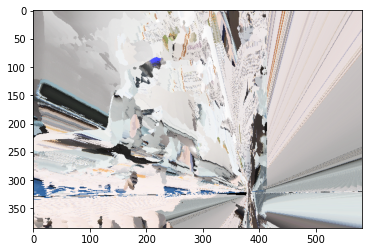

In [50]:
plt.imshow(final_image)

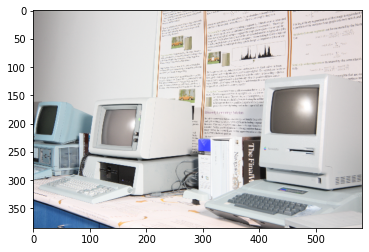

In [51]:
plt.imshow(colorimages[1])

In [52]:
cv2.imwrite("results/Scene1_scratch.png",final_image)

True

### Implementation using inbuilt functions

In [53]:
F1, s1 = in_built_function_implementation(images[0], images[1])
lines1 = cv2.computeCorrespondEpilines(points_ref.reshape(-1,1,2), 1,F1)
lines1= lines1.reshape(-1,3)

In [55]:
map_coord1 = findCorrespondance(images[0], images[1], points_ref, lines1)

0 patch length is zero
1 patch length is zero
2 patch length is zero
582 patch length is zero
583 patch length is zero
584 patch length is zero
1164 patch length is zero
1165 patch length is zero
1166 patch length is zero
1746 patch length is zero
1747 patch length is zero
1748 patch length is zero
2328 patch length is zero
2329 patch length is zero
2330 patch length is zero
2910 patch length is zero
2911 patch length is zero
2912 patch length is zero
3492 patch length is zero
3493 patch length is zero
3494 patch length is zero
4074 patch length is zero
4075 patch length is zero
4076 patch length is zero
4656 patch length is zero
4657 patch length is zero
4658 patch length is zero
5238 patch length is zero
5239 patch length is zero
5240 patch length is zero
5820 patch length is zero
5821 patch length is zero
5822 patch length is zero
6402 patch length is zero
6403 patch length is zero
6404 patch length is zero
6984 patch length is zero
6985 patch length is zero
6986 patch length is zer

In [31]:
final_image1 = reconstructImage(map_coord1, colorimages[0], colorimages[1])

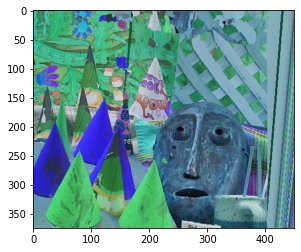

In [32]:
plt.imshow(final_image1)

In [86]:
cv2.imwrite("results/Scene1_inbuilt.png",final_image1)

True